In the first 2 learning units, we saw the so-called **Bag of Words** vectorization of text. Text is transformed in vectors, constituted by counts or frequencies of words. This representation has the advantage of being simple and lasted for a very long time.

A possible improvement to this idea is, instead of considering single words, to consider sequences of them. So, you can create features for 2 consecutives words, or even 3. You can even consider sequences of letters, or phonems. This approach is called **n-grams** reprensentation, and it could be very effective as well. Since we are not going to cover it in this material, you can find a very interesting explanation [here](https://www.youtube.com/watch?v=s3kKlUBa3b0&index=12&list=PL6397E4B26D00A269).

An important breakthrough in text representation has been made during recent past by using deep learning. The family of algorithms called **word embedding** - the most famous being `word2vec` - is based on training neural network to automatically learn the more informative representation for text data. The networks are trained to produce vectors that embed semantic information extracted from text. For example,  words with similar meaning produces vectors that are close to one another in the vector space.

In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# GenSim
import gensim

C:\Users\Paul\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Train those kind of models is **very** computationally expensive. The good news is that, once trained by those guys with the big computers, we can happily use the trained models to project text to the feature space. 

Thankfully, we can go [here](http://nlpserver2.inf.ufrgs.br/alexandres/vectors/lexvec.enwiki%2bnewscrawl.300d.W.pos.vectors.gz) and download a LexVec word embedding model (similar to word2vec and [GloVe](https://nlp.stanford.edu/projects/glove/)) pre-trained on Wikipedia.

Small note: the models have to be trained on text of the same language. So, one of the problems with such an approach is that most of tools are only available for English language.

Another small note: be careful, this will load a **pretty big** object in memory. 

In [4]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./lexvec.enwiki+newscrawl.300d.W.pos.vectors')

As we said earlier, we have some cool properties in this vector space. We can treat words as numbers. What do you expect from `woman + king - man`?

In [5]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6212160587310791),
 ('monarch', 0.5939740538597107),
 ('prince', 0.5655953884124756),
 ('throne', 0.5191947817802429),
 ('princess', 0.5010462403297424),
 ('emperor', 0.4941236674785614),
 ('consort', 0.474475622177124),
 ('empress', 0.4712255299091339),
 ('regent', 0.46504777669906616),
 ('betrothed', 0.4598500430583954)]

Ok, that was nice. Let's see how things work with real data.

In [6]:
df = pd.read_csv('../hackathon-5-learning/02-text-in-practice/data/uci-news-aggregator.csv')
df.dtypes

ID            int64
TITLE        object
URL          object
PUBLISHER    object
CATEGORY     object
STORY        object
HOSTNAME     object
TIMESTAMP     int64
dtype: object

We have already used this dataset in the last notebook but to give you some context, this dataset is made up of a different news headlines and their respective category. Let's look at some samples:

In [7]:
df = df[['TITLE', 'CATEGORY']]
df.columns = ['title', 'category']

df.head()

,title,category
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


Let's plit our data into train and validation set so we can benchmark the final model!

In [8]:
_, data = train_test_split(df, test_size=0.3, random_state=42)  # subsampling to help performance
train_df, validation_df = train_test_split(data, test_size=0.2, random_state=42)

Now that we have the dataset loaded and set up we get into the interesting part, transforming the document from a variable length sequence of words into a fixed length vector representation!

As we have talked about in previous hackathons, categorical features are generally converted not in an integer but in a onehot encoding of the category. That is, giving a small example:

If the possible values of a given feature "gender" would be:

["Male", "Female", "Unknown", "Attack Helicopter"]

The entry with the feature "Male" would be represented as:

(1, 0, 0, 0)

This procedure is important as we don't impose any information about the problem, if we would convert the values into either 1, 2, 3 or 4 we would be giving additional information as we could lead our classifier to believe that unkown and female are similar concepts since 2 and 3 are close on the line of real numbers.

Here is where word vectors come in handy! Word vectors help us find a representation in a continuous space (latent space) where similar words are close in space!

The previous example (woman + (king - queen)) aimed to show the structure of this space.

The model we loaded earlier keeps a dictionary of words and their vector representation in this space (model.wv). Looking at the word vectors of a concrete example:


In [9]:
# Load the word vector for the word "car"
king_vector = model.wv['king']

print("Word vector dimension: ", king_vector.shape)

# Load the word vector for the word "bus" and "cat"
queen_vector = model.wv['queen']
peasant_vector = model.wv['peasant']

print("Similarity between King and Queen: ", np.dot(king_vector, queen_vector))
print("Similarity between Kind and Peasant: ", np.dot(king_vector, peasant_vector))


Word vector dimension:  (300,)
Similarity between King and Queen:  3.93262
Similarity between Kind and Peasant:  0.574412


In this example, we used the dot product as a means of calculating how similar two vectors are, we can see that the model assigns vectors which are similar for "king" and "queen" but separates them in space from the concept of "peasant". 

Small side note: While it is curious to observe a political agenda in a word vector embedding model, this is an example of possible human bias in the input data and alerts to the dangers of giving our models biased data. In the end we are all humans, being peasant or king!     

# Document vector representation

Now that we looked at our first word vectors, we are ready to move on to convert our documents into this space!

We start by splitting our sentences in words (tokens).

In [85]:
# Extract document tokens

tokenizer = tfidf.build_tokenizer()

documents = train_df
tokens = [[word for word in tokenizer(document)] for document in documents['title']]

tokens[0]

['UPDATE',
 'China',
 'factories',
 'struggle',
 'adds',
 'to',
 'expectations',
 'for',
 'stimulus']

Now that we have the sentence sepparated in tokens we can easily convert the tokens into the word vector space using the Word2Vec model's word vector dictionary.

In [72]:
# Convert each token (word) into vector representation
vectors = [np.array([model.wv[token] if token in model.wv else model.wv['the'] for token in sentence]) for sentence in tokens]

Looking at a single sentence, we can see that vectors is an array of matrixes, where each entry is a matrix representation of the sentence. Why matrix you ask? 

It becomes a matrix when we convert the tokens in the sentence to vecctors. Looking at the shape of a sentence we can see that it is of the dimension (9 x 300), where 9 is the number of words in the sentence and 300 the dimension of the word vector space. This means in one sentence we have 9 word vectors where each has a dimension of 300 entries. Sounds about right!

In [81]:
vectors[0].shape

(9, 300)

For each document (sentence), we have now have an array of vectors. One vector for each word. Argh, that's a lot of numbers! We can "summarize" each document 

There are far smarter ways to do that, but to keep things simple, we can take the mean of all the words. We end up with a fixed size vector for each document!:

In [13]:
# Average word vectors to get document representation
vectorized = np.array([document.mean(axis=0) for document in vectors])
vectorized.shape

(101380, 300)

Looking at a single entry we can see that the dimension of the sentence representation is 300, this is natural since we averaged the representation of all the vectors in the sentence! 

Like everything in life, there is no free lunch! By reducing the array of vectors to a fixed sized representtion of 300 by averaging the word vectors we loose some information! Nevertheless this averaged representation captures the average location of words in the word vector space! 

For example, if the sentence is made up of words in the general field of finance, the average of these word vectors would be somewhere in the finance region of the word vector space.

In [80]:
model.wv.similar_by_vector(vectorized[0], topn=10, restrict_vocab=None)

[('the', 0.6818545460700989),
 ('its', 0.5417273640632629),
 ('for', 0.5124319791793823),
 ('to', 0.5122223496437073),
 ('expectations', 0.5094152688980103),
 ('this', 0.4959806203842163),
 ('next', 0.49031582474708557),
 ('stimulus', 0.48270300030708313),
 ('another', 0.4665628671646118),
 ('in', 0.46378690004348755)]

This does not seem to be a very interesting representation! 

Let's try to fix this by weighting the average by the term frequencies so these generic words are ignored!

We start by creating a dictionary of the term frequencies:

In [47]:
tfidf = TfidfVectorizer(preprocessor=lambda x: x)
tfidf.fit(train_df['title'])

tfidf_dictionary = {w: tfidf.idf_[i] for w, i in tfidf.vocabulary_.items()}

Then we create a vector with each sentences token weights and average the word vectors using this weighting vector.

In [98]:
weights = [[tfidf_dictionary[token] for token in sequence] for sequence in tokens]
weighted_vectors = np.array([np.average(vectors[i], weights=weights[i], axis=0) for i in range(0, len(documents))])

In [86]:
model.wv.similar_by_vector(weighted_vectors[0], topn=10, restrict_vocab=None)

[('expectations', 0.5419510006904602),
 ('economy', 0.5358553528785706),
 ('stimulus', 0.5331944823265076),
 ('slowdown', 0.5285102725028992),
 ('downturn', 0.524492621421814),
 ('sluggish', 0.5207642912864685),
 ('demand', 0.520745038986206),
 ('worries', 0.517106294631958),
 ('jobs', 0.5140954256057739),
 ('growth', 0.5140053033828735)]

Correcting for the term frequencies we were able to get a much better document representation! 

Each document is now a 300-dimensional vector. 300 dimensions are not so many, but it's still a challenge to visualize them. 

We should definitely try out a couple of dimensionality reduction algorithms to reduce the space to a nice 2-dimensional cartesian space.

In [87]:
labels = documents['category']

color_map = {'b':'r', 't':'g', 'e':'b', 'm':'c'}
colors = [color_map[label] for label in labels]
size = [10 for i in range(len(labels))]

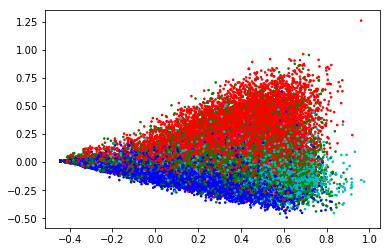

In [90]:
reduced_data = PCA(n_components=2).fit_transform(weighted_vectors)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

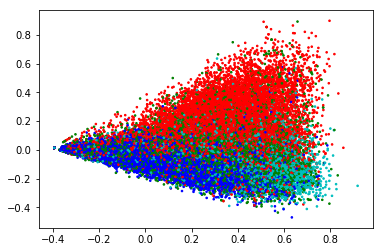

In [91]:
reduced_data = PCA(n_components=2).fit_transform(vectorized)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

In [119]:
len(weighted_vectors)
sample_idxs = random.sample(range(1, 100000), 10000)
subsample_weighted_vectors = (PCA(n_components=10).fit_transform(weighted_vectors))[sample_idxs]
subsample_vectorized = PCA(n_components=10).fit_transform(vectorized)[sample_idxs]

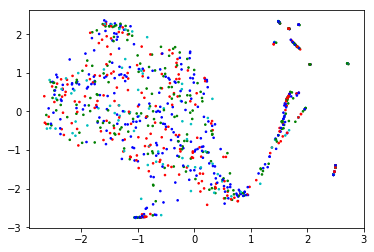

In [118]:
reduced_data = TSNE(n_components=2).fit_transform(vectorized)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

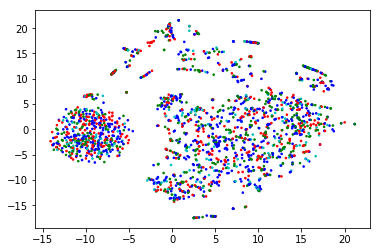

In [110]:
reduced_data = TSNE(n_components=2, n_iter=6000, perplexity=50, learning_rate=30, early_exaggeration=1).fit_transform(subsample_vectorized)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

In [24]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

clf = LinearSVC(C=1)

clf.fit(vectorized, documents['category'])

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
def vectorize(documents):
    tokens = [[word for word in document.split()] for document in documents['title']]
    vectors = [np.array([model.wv[token] if token in model.wv else model.wv['the'] for token in sentence]) for sentence in tokens]
    return np.array([document.mean(axis=0) for document in vectors])
    
vectorized_test = vectorize(validation_df)
predicted = clf.predict(vectorized_test)
np.mean(predicted == validation_df['category'])

0.60983981693363842